In [88]:
import pandas as pd
import numpy as np
import glmnet_python
import statsmodels.api as sm
from glmnet import glmnet
from scipy import optimize
import scipy as sc
import datetime
from dateutil.relativedelta import relativedelta
import math


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import ClassifierChain

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt #for plots
%matplotlib inline


In [2]:
#Get data
df_m = pd.read_csv('df_m.csv', index_col = 'Date')
df_q = pd.read_csv('df_q.csv', index_col = 'Date')
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)
df_q.index = pd.to_datetime(df_q.index)

In [ ]:
df_m.describe()

In [3]:
#Genertating a list containing only the monthly input variables
predictors_m = list(df_m.columns)
predictors_m = predictors_m[1:]

# Normalize predictors
df_m[predictors_m] = MinMaxScaler().fit_transform(df_m[predictors_m])
df_m.describe()

,USREC,GS10,TB3MS,GS1,AAA10YM,DTB6,BAA10YM,FEDFUNDS,WPU102301,WPU101,...,R_Unfilled Orders,R_W875RX1,R_MABMM301USM189S,R_S&P500,R_S&P500_change,USREC_lag3,USREC_lag6,mad_10Y-3M,mad_10Y-1Y,mad_S&P500
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,...,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,0.119253,0.334285,0.281841,0.300882,0.418597,0.299965,0.306331,0.263113,0.248877,0.338349,...,0.438386,0.303379,0.337617,0.271984,0.684794,0.119253,0.119253,0.096968,0.085129,0.099517
std,0.324319,0.209755,0.195656,0.204381,0.201105,0.202249,0.139384,0.194299,0.262095,0.252643,...,0.082574,0.338186,0.250197,0.234793,0.105797,0.324319,0.324319,0.099275,0.085721,0.125111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.184515,0.136587,0.146661,0.270175,0.144955,0.218531,0.119285,0.074273,0.135229,...,0.390560,0.081872,0.157534,0.095552,0.630180,0.000000,0.000000,0.044202,0.038390,0.010615
50%,0.000000,0.316570,0.289441,0.301745,0.391228,0.308110,0.295455,0.257488,0.123514,0.318318,...,0.437226,0.120503,0.272869,0.155325,0.695937,0.000000,0.000000,0.070024,0.059373,0.036802
75%,0.000000,0.454595,0.377686,0.414110,0.565789,0.407088,0.393794,0.356542,0.306985,0.541761,...,0.483653,0.541705,0.468042,0.438684,0.753963,0.000000,0.000000,0.113449,0.099195,0.161652
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_q.describe()

In [4]:
#Genertating a list containing only the quaterly input variables
predictors_q = list(df_q.columns)
predictors_q = predictors_q[1:]

# Normalize predictors
df_q[predictors_q] = MinMaxScaler().fit_transform(df_q[predictors_q])
df_q.describe()

,GDPC1,GDPC1_lag1,GDPC1_lag2,GS10,TB3MS,GS1,AAA10YM,DTB6,BAA10YM,FEDFUNDS,...,R_M2NS,R_Unfilled Orders,R_W875RX1,R_MABMM301USM189S,R_S&P500,R_S&P500_change,USREC_lag6,mad_10Y-3M,mad_10Y-1Y,mad_S&P500
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.735912,0.497899,0.498890,0.343022,0.305044,0.308160,0.395949,0.310756,0.317061,0.282589,...,0.334818,0.591798,0.302638,0.338407,0.276217,0.669350,0.119253,0.171513,0.142364,0.117808
std,0.791027,0.133970,0.134541,0.217978,0.211082,0.208890,0.222318,0.209670,0.151923,0.207753,...,0.251743,0.137689,0.341014,0.252526,0.244524,0.154934,0.312714,0.150994,0.130407,0.143793
min,-2.211668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351949,0.432156,0.432156,0.185696,0.147773,0.145735,0.235621,0.150044,0.215157,0.128718,...,0.152258,0.503944,0.080441,0.156620,0.093522,0.595320,0.000000,0.088112,0.068793,0.012887
50%,0.745878,0.499652,0.500420,0.325972,0.312943,0.309661,0.366667,0.318664,0.310854,0.273155,...,0.268789,0.592570,0.118332,0.273244,0.152477,0.695908,0.000000,0.130426,0.104765,0.042232
75%,1.098551,0.560852,0.563854,0.464680,0.408300,0.423690,0.552288,0.423706,0.410244,0.378671,...,0.463242,0.678735,0.542854,0.468522,0.452786,0.762781,0.000000,0.189236,0.162233,0.195207
max,3.720482,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Categories distribution for monthly

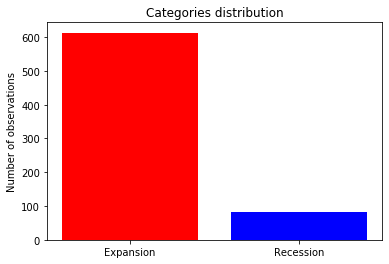

In [5]:
bars = ('Expansion', 'Recession')
y_pos = np.arange(len(bars))
height = df_m['USREC'].value_counts()


plt.bar(y_pos, height, color=['red', 'blue'])
plt.xticks(y_pos, bars)
plt.title('Categories distribution')
plt.ylabel('Number of observations')
plt.show()

In [7]:
#I need the depedent variable to have multiple horizons
m_hrz_lst = ['USREC']
for i in [1,3,6,9,12]:
    df_m['USREC+'+str(i)] = df_m['USREC'].shift(-i)
    m_hrz_lst.append('USREC+'+str(i))

y_m = df_m[m_hrz_lst]
x_m = df_m.drop(columns = m_hrz_lst)

M_X_train, M_X_test, M_y_train, M_y_test = train_test_split(x_m, y_m,
                         test_size=0.25, shuffle = False)

In [8]:
#I need the depedent variable to have multiple horizons
q_hrz_lst = ['GDPC1']
for i in [1,2,3,4]:
    df_q['GDPC1+'+str(i)] = df_q['GDPC1'].shift(-i)
    q_hrz_lst.append('GDPC1+'+str(i))

y_q = df_q[q_hrz_lst]
x_q = df_q.drop(columns = q_hrz_lst)

Q_X_train, Q_X_test, Q_y_train, Q_y_test = train_test_split(x_q, y_q,
                         test_size=0.5, shuffle = False)

In [78]:
def QPS(prediction_probability, Truth):
    qps_lst = []
    for i in range(len(prediction_probability)):
        qps_lst.append(2*(prediction_probability[i] - Truth[i])**2)
    qps_sum = sum(qps_lst)
    return (qps_sum/len(prediction_probability))

# Sklearn

# Monthly Train trainCvSplit a hrz_0

In [ ]:
#I need the index to be a datetime object
#This method only predicts one recession, misses the other 2
df_m.index = pd.to_datetime(df_m.index)

#CHANGE ALL THE m0_tcis VARIABLES

#CHANGE THIS WITH THE HORIZON
#hrz_str = str(0) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
#y_m = df_m['USREC+'+hrz_str]
y_m = df_m['USREC']
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m0_tcis = []
loss_m0_tcis = []
predicted_m0_tcis = np.array([])
pred_proba_m0_tcis = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tcis = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
    
    model_m0_tcis = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tcis,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m0_tcis.predict(XTest)
    ypred_proba =  model_m0_tcis.predict_proba(XTest)
    predicted_m0_tcis = np.append(predicted_m0_tcis, model_m0_tcis.predict(XTest))
    pred_proba_m0_tcis = np.append(pred_proba_m0_tcis, model_m0_tcis.predict_proba(XTest))

    rmse_m0_tcis.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m0_tcis.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m0_tcis)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m0_tcis))))

#Plotting
predicted_m0_tcis = predicted_m0_tcis.tolist()
pred_proba_m0_tcis = pred_proba_m0_tcis.tolist()
pred_proba_m0_tcis = pred_proba_m0_tcis[1::2] #Slicing becasue both probabilities are reported
end_date_m0_tcis = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m0_tcis = pd.date_range(start="1990-02-01",
                          end=str(end_date_m0_tcis),
                         freq = 'M')

plt.plot(testdates_m0_tcis, pred_proba_m0_tcis, label = 'Logistic Regression: m0_tcis horizon')
plt.plot(testdates_m0_tcis, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])


# Monthly Train tscv a hrz_0

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

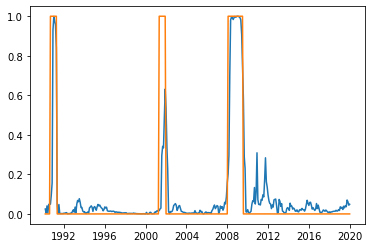

In [51]:
#I need the index to be a datetime object
#This method only predicts one recession, misses the other 2
df_m.index = pd.to_datetime(df_m.index)

#CHANGE ALL THE m0 VARIABLES

#CHANGE THIS WITH THE HORIZON
#hrz_str = str(0) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
#y_m = df_m['USREC+'+hrz_str]
y_m = df_m['USREC']
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m0 = []
loss_m0 = []
predicted_m0 = np.array([])
pred_proba_m0 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m0 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m0.predict(XTest)
    ypred_proba =  model_m0.predict_proba(XTest)
    predicted_m0 = np.append(predicted_m0, model_m0.predict(XTest))
    pred_proba_m0 = np.append(pred_proba_m0, model_m0.predict_proba(XTest))

    rmse_m0.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m0.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m0)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m0))))

#Plotting
predicted_m0 = predicted_m0.tolist()
pred_proba_m0 = pred_proba_m0.tolist()
pred_proba_m0 = pred_proba_m0[1::2] #Slicing becasue both probabilities are reported
end_date_m0 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m0 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m0),
                         freq = 'M')

plt.plot(testdates_m0, pred_proba_m0, label = 'Logistic Regression: m0 horizon')
plt.plot(testdates_m0, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])


# Monthly Train trainCVsplit with Classifier Chain

In [30]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tcis = df_m[m_hrz_lst]
y_m_all_tcis = y_m.dropna()
x_m_all_tcis = df_m.drop(columns = m_hrz_lst)
x_m_all_tcis = x_m_all_tcis[:y_m_all_tcis.shape[0]]

n_splits = len(x_m_all_tcis)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tcis)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tcis = []
loss_m_all_tcis = []
predicted_m_all_tcis = np.array([])
pred_proba_m_all_tcis = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tcis.iloc[trainCvIndices,0:], y_m_all_tcis.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tcis.iloc[testIndices,0:]   , y_m_all_tcis.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    tcis = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
    
    #Model construction and wrapper
    model_m_all_tcis = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tcis,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = ClassifierChain(model_m_all_tcis)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tcis = wrapper.predict(XTest)
    ypred_proba_m_all_tcis =  wrapper.predict_proba(XTest)
    predicted_m_all_tcis = np.append(predicted_m_all_tcis, ypredicted_m_all_tcis)
    pred_proba_m_all_tcis = np.append(pred_proba_m_all_tcis, ypred_proba_m_all_tcis)
    
    #Errors calcualtion
    rmse_m_all_tcis.append(math.sqrt(mean_squared_error(yTest, ypredicted_m_all_tcis)))
    loss_m_all_tcis.append(mean_squared_log_error(yTest, ypredicted_m_all_tcis, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m_all_tcis)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m_all_tcis))))

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

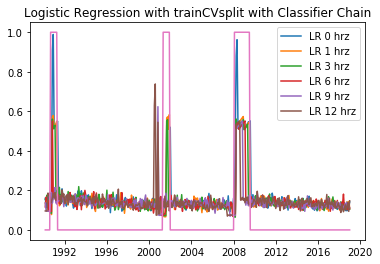

In [41]:
from pandas.plotting import register_matplotlib_converters

# predicted_m_all_tcis = predicted_m_all_tcis.tolist()
# pred_proba_m_all_tcis = pred_proba_m_all_tcis.tolist()
pred_proba_lst_0 = pred_proba_m_all_tcis[0::6]
pred_proba_lst_1 = pred_proba_m_all_tcis[1::6]
pred_proba_lst_3 = pred_proba_m_all_tcis[2::6]
pred_proba_lst_6 = pred_proba_m_all_tcis[3::6]
pred_proba_lst_9 = pred_proba_m_all_tcis[4::6]
pred_proba_lst_12 = pred_proba_m_all_tcis[5::6]
testdates_m_all_tcis = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')

plt.plot(testdates_m_all_tcis, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_all_tcis, pred_proba_lst_1, label = 'LR 1 hrz')
plt.plot(testdates_m_all_tcis, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_all_tcis, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_all_tcis, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_all_tcis, pred_proba_lst_12, label = 'LR 12 hrz')
plt.plot(testdates_m_all_tcis, df_m['USREC']['1990-02-01':"2018-12-01"])
plt.title('Logistic Regression with trainCVsplit with Classifier Chain')
plt.legend()
plt.show()

# Monthly Train tscv with Classifier chain


In [48]:
#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_tscv = df_m[m_hrz_lst]
y_m_all_tscv = y_m.dropna()
x_m_all_tscv = df_m.drop(columns = m_hrz_lst)
x_m_all_tscv = x_m_all_tscv[:y_m_all_tscv.shape[0]]

n_splits = len(x_m_all_tscv)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_tscv)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m_all_tscv = []
loss_m_all_tscv = []
predicted_m_all_tscv = np.array([])
pred_proba_m_all_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_tscv.iloc[trainCvIndices,0:], y_m_all_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_tscv.iloc[testIndices,0:]   , y_m_all_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    #Model construction and wrapper
    #Need to use list(tscv) becasue not possible to pickle generators
    model_m_all_tscv = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = list(tscv),
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = ClassifierChain(model_m_all_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_tscv = wrapper.predict(XTest)
    ypred_proba_m_all_tscv =  wrapper.predict_proba(XTest)
    predicted_m_all_tscv = np.append(predicted_m_all_tscv, ypredicted_m_all_tscv)
    pred_proba_m_all_tscv = np.append(pred_proba_m_all_tscv, ypred_proba_m_all_tscv)
    
    #Errors calcualtion
    rmse_m_all_tscv.append(math.sqrt(mean_squared_error(yTest, ypredicted_m_all_tscv)))
    loss_m_all_tscv.append(mean_squared_log_error(yTest, ypredicted_m_all_tscv, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m_all_tscv)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m_all_tscv))))

Training: 1962-01-01 -- 1989-12-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-02-01 -- 1990-02-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-02-01 -- 1990-02-01 , Test: 1990-03-01 -- 1990-03-01
Training: 1962-01-01 -- 1990-02-01 , Cv: 1990-03-01 -- 1990-03-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-03-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-05-01 -- 1990-05-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-05-01 -- 1990-05-01 , Test: 1990-06-01 -- 1990-06-01
Training: 1962-01-01 -- 1990-05-01 , Cv: 1990-06-01 -- 1990-06-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-06-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-08-01 -- 1990-08-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-08-01 -- 1990-08-01 , Test: 1990-09-01 -- 1990-09-01
Training: 1962-01-01 -- 1990-08-01 , Cv: 1990-09-01 -- 1990-09-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-09-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1990-11-01 -- 1990-11-01
Training: 

Training: 1962-01-01 -- 1996-11-01 , Cv: 1996-12-01 -- 1996-12-01 , Test: 1997-01-01 -- 1997-01-01
Training: 1962-01-01 -- 1996-12-01 , Cv: 1997-01-01 -- 1997-01-01 , Test: 1997-02-01 -- 1997-02-01
Training: 1962-01-01 -- 1997-01-01 , Cv: 1997-02-01 -- 1997-02-01 , Test: 1997-03-01 -- 1997-03-01
Training: 1962-01-01 -- 1997-02-01 , Cv: 1997-03-01 -- 1997-03-01 , Test: 1997-04-01 -- 1997-04-01
Training: 1962-01-01 -- 1997-03-01 , Cv: 1997-04-01 -- 1997-04-01 , Test: 1997-05-01 -- 1997-05-01
Training: 1962-01-01 -- 1997-04-01 , Cv: 1997-05-01 -- 1997-05-01 , Test: 1997-06-01 -- 1997-06-01
Training: 1962-01-01 -- 1997-05-01 , Cv: 1997-06-01 -- 1997-06-01 , Test: 1997-07-01 -- 1997-07-01
Training: 1962-01-01 -- 1997-06-01 , Cv: 1997-07-01 -- 1997-07-01 , Test: 1997-08-01 -- 1997-08-01
Training: 1962-01-01 -- 1997-07-01 , Cv: 1997-08-01 -- 1997-08-01 , Test: 1997-09-01 -- 1997-09-01
Training: 1962-01-01 -- 1997-08-01 , Cv: 1997-09-01 -- 1997-09-01 , Test: 1997-10-01 -- 1997-10-01
Training: 

Training: 1962-01-01 -- 2003-10-01 , Cv: 2003-11-01 -- 2003-11-01 , Test: 2003-12-01 -- 2003-12-01
Training: 1962-01-01 -- 2003-11-01 , Cv: 2003-12-01 -- 2003-12-01 , Test: 2004-01-01 -- 2004-01-01
Training: 1962-01-01 -- 2003-12-01 , Cv: 2004-01-01 -- 2004-01-01 , Test: 2004-02-01 -- 2004-02-01
Training: 1962-01-01 -- 2004-01-01 , Cv: 2004-02-01 -- 2004-02-01 , Test: 2004-03-01 -- 2004-03-01
Training: 1962-01-01 -- 2004-02-01 , Cv: 2004-03-01 -- 2004-03-01 , Test: 2004-04-01 -- 2004-04-01
Training: 1962-01-01 -- 2004-03-01 , Cv: 2004-04-01 -- 2004-04-01 , Test: 2004-05-01 -- 2004-05-01
Training: 1962-01-01 -- 2004-04-01 , Cv: 2004-05-01 -- 2004-05-01 , Test: 2004-06-01 -- 2004-06-01
Training: 1962-01-01 -- 2004-05-01 , Cv: 2004-06-01 -- 2004-06-01 , Test: 2004-07-01 -- 2004-07-01
Training: 1962-01-01 -- 2004-06-01 , Cv: 2004-07-01 -- 2004-07-01 , Test: 2004-08-01 -- 2004-08-01
Training: 1962-01-01 -- 2004-07-01 , Cv: 2004-08-01 -- 2004-08-01 , Test: 2004-09-01 -- 2004-09-01
Training: 

Training: 1962-01-01 -- 2010-09-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2010-11-01 -- 2010-11-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2010-11-01 -- 2010-11-01 , Test: 2010-12-01 -- 2010-12-01
Training: 1962-01-01 -- 2010-11-01 , Cv: 2010-12-01 -- 2010-12-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-12-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-02-01 -- 2011-02-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-02-01 -- 2011-02-01 , Test: 2011-03-01 -- 2011-03-01
Training: 1962-01-01 -- 2011-02-01 , Cv: 2011-03-01 -- 2011-03-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-03-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-05-01 -- 2011-05-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-05-01 -- 2011-05-01 , Test: 2011-06-01 -- 2011-06-01
Training: 1962-01-01 -- 2011-05-01 , Cv: 2011-06-01 -- 2011-06-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-06-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-08-01 -- 2011-08-01
Training: 

Training: 1962-01-01 -- 2017-08-01 , Cv: 2017-09-01 -- 2017-09-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-09-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2017-11-01 -- 2017-11-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2017-11-01 -- 2017-11-01 , Test: 2017-12-01 -- 2017-12-01
Training: 1962-01-01 -- 2017-11-01 , Cv: 2017-12-01 -- 2017-12-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-12-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-02-01 -- 2018-02-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-02-01 -- 2018-02-01 , Test: 2018-03-01 -- 2018-03-01
Training: 1962-01-01 -- 2018-02-01 , Cv: 2018-03-01 -- 2018-03-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-03-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-05-01 -- 2018-05-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-05-01 -- 2018-05-01 , Test: 2018-06-01 -- 2018-06-01
Training: 1962-01-01 -- 2018-05-01 , Cv: 2018-06-01 -- 2018-06-01 , Test: 2018-07-01 -- 2018-07-01
Training: 

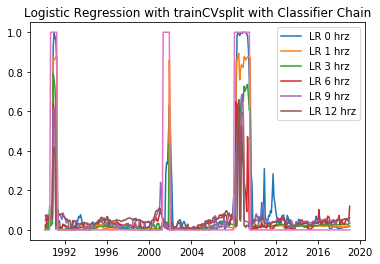

In [50]:
pred_proba_m_all_tscv = pred_proba_m_all_tscv.tolist()
pred_proba_lst_0 = pred_proba_m_all_tscv[0::6]
pred_proba_lst_1 = pred_proba_m_all_tscv[1::6]
pred_proba_lst_3 = pred_proba_m_all_tscv[2::6]
pred_proba_lst_6 = pred_proba_m_all_tscv[3::6]
pred_proba_lst_9 = pred_proba_m_all_tscv[4::6]
pred_proba_lst_12 = pred_proba_m_all_tscv[5::6]
testdates_m_all_tscv = pd.date_range(start = "1990-02-01",
                          end = "2019-01-01",
                         freq = 'M')

plt.plot(testdates_m_all_tscv, pred_proba_lst_0, label = 'LR 0 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_1, label = 'LR 1 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_3, label = 'LR 3 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_6, label = 'LR 6 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_9, label = 'LR 9 hrz')
plt.plot(testdates_m_all_tscv, pred_proba_lst_12, label = 'LR 12 hrz')
plt.plot(testdates_m_all_tscv, df_m['USREC']['1990-02-01':"2018-12-01"])
plt.title('Logistic Regression with trainCVsplit with Classifier Chain')
plt.legend()
plt.show()

In [97]:
rmse_m_all_tscv

[0.7071067811865476,
 0.7071067811865476,
 0.5773502691896257,
 0.7071067811865476,
 0.7071067811865476,
 0.7071067811865476,
 0.816496580927726,
 0.816496580927726,
 0.7071067811865476,
 0.5773502691896257,
 0.5773502691896257,
 0.7071067811865476,
 0.408248290463863,
 0.408248290463863,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.408248290463863,
 0.408248290463863,
 0.408248290463863,
 0

In [95]:
#Uncomment below when needed
#predicted_m_all_tscv = predicted_m_all_tscv.tolist()
pred_proba_m_all_tscv = pred_proba_m_all_tscv.tolist()


def error_metrics(yprob, ypred, ytest):
    error_lst = [QPS(yprob, ytest),
                 log_loss(ytest, yprob), 
                 accuracy_score(ytest, ypred),
                 roc_auc_score(ytest,ypred),
                 confusion_matrix(ytest, ypred)[0, 1],
                 confusion_matrix(ytest, ypred)[1, 0]
                ]
    return error_lst

predicted_lst_0 = predicted_m_all_tscv[0::6]
yTest_m0 = df_m['USREC']['1990-02-01':'2018-12-01']
errors_0 = error_metrics(predicted_lst_0, yTest_m0)

predicted_lst_1 = predicted_m_all_tscv[1::6]
yTest_m1 = df_m['USREC+1']['1990-02-01':'2018-12-01']
errors_1 = error_metrics(predicted_lst_1, yTest_m1)

predicted_lst_3 = predicted_m_all_tscv[2::6]
yTest_m3 = df_m['USREC+3']['1990-02-01':'2018-12-01']
errors_3 = error_metrics(predicted_lst_3, yTest_m3)

predicted_lst_6 = predicted_m_all_tscv[3::6]
yTest_m6 = df_m['USREC+6']['1990-02-01':'2018-12-01']
errors_6 = error_metrics(predicted_lst_6, yTest_m6)

predicted_lst_9 = predicted_m_all_tscv[4::6]
yTest_m9 = df_m['USREC+9']['1990-02-01':'2018-12-01']
errors_9 = error_metrics(predicted_lst_9, yTest_m9)

predicted_lst_12 = predicted_m_all_tscv[5::6]
yTest_m12 = df_m['USREC+12']['1990-02-01':'2018-12-01']
errors_12 = error_metrics(predicted_lst_12, yTest_m12)
errors_tscv_chain = pd.DataFrame(data = [errors_0,
                                        errors_1,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_1',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['QPS', 'LogLoss', 'Accuracy',
                                           'ROC AUC score', 'False Positives', 
                                           'False Negatives'])


#THIS IS THE CORRECT WAY TO CALCULATE MEAN SQUARE ERROR
#SQUARING INSIDE THE FOR LOOP IS INCORRECT TO CALCULATE RMSE
#THIS IS BECAUSE IT SQUARES THE MONTHLY MSE RATHER THAN THE TOTAL MSE
print("RMSE: {0:.3f}".format(math.sqrt(mean_squared_error(yTest_m0, predicted_lst_0))))
print(("LogLoss: {0:.3f}".format(log_loss(yTest_m0, predicted_lst_0))))
errors_tscv_chain

RMSE: 0.201
LogLoss: 1.393


,QPS,LogLoss,Accuracy,ROC AUC score,False Positives,False Negatives
lag_0,0.080692,1.393500,0.959654,0.820335,2,12
lag_1,0.115274,1.990719,0.942363,0.771425,5,15
lag_3,0.144092,2.488398,0.927954,0.711004,6,19
lag_6,0.172911,2.986068,0.913545,0.598149,3,27
lag_9,0.190202,3.284679,0.904899,0.540476,5,28
lag_12,0.155620,2.687458,0.922190,0.534147,1,26


# Monthly Train tscv a hrz_1

In [ ]:
#I need the index to be a datetime object
#This method only predicts one recession, misses the other 2
df_m.index = pd.to_datetime(df_m.index)

#CHANGE ALL THE m1 VARIABLES

#CHANGE THIS WITH THE HORIZON
hrz_str = str(1) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
y_m = df_m['USREC+'+hrz_str]
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m1 = []
loss_m1 = []
predicted_m1 = np.array([])
pred_proba_m1 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m1 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m1.predict(XTest)
    ypred_proba =  model_m1.predict_proba(XTest)
    predicted_m1 = np.append(predicted_m1, model_m1.predict(XTest))
    pred_proba_m1 = np.append(pred_proba_m1, model_m1.predict_proba(XTest))

    rmse_m1.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m1.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m1)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m1))))

#Plotting
predicted_m1 = predicted_m1.tolist()
pred_proba_m1 = pred_proba_m1.tolist()
pred_proba_m1 = pred_proba_m1[1::2] #Slicing becasue both probabilities are reported
end_date_m1 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m1 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m1),
                         freq = 'M')

plt.plot(testdates_m1, pred_proba_m1, label = 'Logistic Regression: m1 horizon')
plt.plot(testdates_m1, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])


In [ ]:
end_date_m1

# Monthly Train tscv a hrz_3

In [ ]:
#CHANGE ALL THE M3 VARIABLES

#CHANGE THIS WITH THE HORIZON
hrz_str = str(3) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
y_m = df_m['USREC+'+hrz_str]
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m3 = []
loss_m3 = []
predicted_m3 = np.array([])
pred_proba_m3 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m3 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m3.predict(XTest)
    ypred_proba =  model_m3.predict_proba(XTest)
    predicted_m3 = np.append(predicted_m3, model_m3.predict(XTest))
    pred_proba_m3 = np.append(pred_proba_m3, model_m3.predict_proba(XTest))

    rmse_m3.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m3.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m3)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m3))))

#Plotting
predicted_m3 = predicted_m3.tolist()
pred_proba_m3 = pred_proba_m3.tolist()
pred_proba_m3 = pred_proba_m3[1::2] #Slicing becasue both probabilities are reported
end_date_m3 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m3 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m3),
                         freq = 'M')

plt.plot(testdates_m3, pred_proba_m3, label = 'Logistic Regression: m3 horizon')
plt.plot(testdates_m3, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])

# Monthly Train tscv a hrz_6

In [ ]:
#CHANGE THIS WITH THE HORIZON
hrz_str = str(6) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
y_m = df_m['USREC+'+hrz_str]
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m6 = []
loss_m6 = []
predicted_m6 = np.array([])
pred_proba_m6 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m6 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m6.predict(XTest)
    ypred_proba =  model_m6.predict_proba(XTest)
    predicted_m6 = np.append(predicted_m6, model_m6.predict(XTest))
    pred_proba_m6 = np.append(pred_proba_m6, model_m6.predict_proba(XTest))

    rmse_m6.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m6.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m6)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m6))))

#Plotting
predicted_m6 = predicted_m6.tolist()
pred_proba_m6 = pred_proba_m6.tolist()
pred_proba_m6 = pred_proba_m6[1::2] #Slicing becasue both probabilities are reported
end_date_m6 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m6 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m6),
                         freq = 'M')

plt.plot(testdates_m6, pred_proba_m6, label = 'Logistic Regression: m6 horizon')
plt.plot(testdates_m6, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])

In [ ]:
end_date_m6

# Monthly Train tscv a hrz_9

In [ ]:
#CHANGE THIS WITH THE HORIZON
hrz_str = str(9) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON
y_m = df_m['USREC+'+hrz_str]
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m9 = []
loss_m9 = []
predicted_m9 = np.array([])
pred_proba_m9 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m9 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m9.predict(XTest)
    ypred_proba =  model_m9.predict_proba(XTest)
    predicted_m9 = np.append(predicted_m9, model_m9.predict(XTest))
    pred_proba_m9 = np.append(pred_proba_m9, model_m9.predict_proba(XTest))

    rmse_m9.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m9.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m9)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m9))))

#Plotting
predicted_m9 = predicted_m9.tolist()
pred_proba_m9 = pred_proba_m9.tolist()
pred_proba_m9 = pred_proba_m9[1::2] #Slicing becasue both probabilities are reported
end_date_m9 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m9 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m9),
                         freq = 'M')

plt.plot(testdates_m9, pred_proba_m9, label = 'Logistic Regression: m9 horizon')
plt.plot(testdates_m9, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])

In [ ]:
end_date_m9

# Monthly Train tscv a hrz_12
- This one doesn't have error at the end because the trainTestsplit is done on x_m rather than df_m. Also n_splits changed to reflect the different number of observations with longer horizons

In [ ]:
#CHANGE THIS WITH THE HORIZON
hrz_str = str(12) #CHANGE THIS WITH THE HORIZON
#CHANGE THIS WITH THE HORIZON

y_m = df_m['USREC+'+hrz_str]
y_m = y_m.dropna()
x_m = df_m.drop(columns = m_hrz_lst)
x_m = x_m[:y_m.shape[0]]

n_splits = len(x_m)-2 #Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

rmse_m12 = []
loss_m12 = []
predicted_m12 = np.array([])
pred_proba_m12 = np.array([])
#Train-test split
for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
    XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

   #Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    for i in range(1): #Skip first fold because no recessions
        next(tscv)
    
    model_m12 = LogisticRegressionCV(
            Cs = 100,
            penalty = 'l1',
            solver = 'saga',
            cv = tscv,
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True).fit(XTrainCv,yTrainCv)

    ypredicted = model_m12.predict(XTest)
    ypred_proba =  model_m12.predict_proba(XTest)
    predicted_m12 = np.append(predicted_m12, model_m12.predict(XTest))
    pred_proba_m12 = np.append(pred_proba_m12, model_m12.predict_proba(XTest))

    rmse_m12.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
    #score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))
    loss_m12.append(mean_squared_log_error(yTest, ypredicted, multioutput = 'raw_values'))

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
#Errors
print("RMSE: {0:.3f}".format(np.mean(rmse_m12)))
print(("LogLoss: {0:.3f}".format(np.mean(loss_m12))))

#Plotting
predicted_m12 = predicted_m12.tolist()
pred_proba_m12 = pred_proba_m12.tolist()
pred_proba_m12 = pred_proba_m12[1::2] #Slicing becasue both probabilities are reported
end_date_m12 = XTest.index[-1].date() + relativedelta(months=+1)
testdates_m12 = pd.date_range(start="1990-02-01",
                          end=str(end_date_m12),
                         freq = 'M')

plt.plot(testdates_m12, pred_proba_m12, label = 'Logistic Regression: m12 horizon')
plt.plot(testdates_m12, df_m['USREC']['1990-02-01':str(XTest.index[-1].date())])

In [ ]:
end_date_m12

# EM model benchmark

In [ ]:
df_m[['10Y-3M','R_S&P500']]

#I need the index to be a datetime object
df_m.index = pd.to_datetime(df_m.index)

y_m_all_em = df_m[m_hrz_lst]
y_m_all_em = y_m.dropna()
x_m_all_em = df_m[['10Y-3M','R_S&P500']]
x_m_all_em = x_m_all_em[:y_m_all_em.shape[0]]

n_splits = len(x_m_all_em)-2
#Number of train/cv/test folds
#58 or 57 is the number for annual splits more or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_m_all_em)
for i in range(28*12):
    next(trainTestSplit)#Skip the first fold

predicted_m_all_em = np.array([])
pred_proba_m_all_em = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_m_all_em.iloc[trainCvIndices,0:], y_m_all_em.iloc[trainCvIndices,0:]
    XTest, yTest       = x_m_all_em.iloc[testIndices,0:]   , y_m_all_em.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    #Model construction and wrapper
    #Need to use list(em) becasue not possible to pickle generators
    model_m_all_em = LogisticRegression(
            solver = 'saga',
            max_iter = 10000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True)
    wrapper = MultiOutputClassifier(model_m_all_em)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_m_all_em = wrapper.predict(XTest)
    ypred_proba_m_all_em =  wrapper.predict_proba(XTest)
    predicted_m_all_em = np.append(predicted_m_all_em, ypredicted_m_all_em)
    pred_proba_m_all_em = np.append(pred_proba_m_all_em, ypred_proba_m_all_em)
    
    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

# Next Steps:

# Getting parameters for last model

# Benchmark model Naive yes or no?

# Benchmark prediction Survery Profesional Forecasters

# Quaterly model


In [ ]:
def Log_Penalty_Tscv(data, hrz, no_c = 10, pen = 'l1', solv_alg = 'saga', no_iter = 1000):
    '''data is dataframe with all the predictors and dependent variables
    hrz is the prediction horizon in number of months ahead
    no_c is number of parameters for grid search
    pen is string to define penalty (l1, l2 or elasticnet)
    solv_alg is the algorithm used (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)
    n.b. elasticnet is only supported by saga, more info at LogisticRegressionCV guide
    no_iter is the maximum number of iterations to fit the Logistic regression model'''
    
    hrz_str = str(hrz)
    y_m = data['USREC+'+hrz_str]
    y_m = y_m.dropna()
    m_hrz_lst = ['USREC']
    x_m = df_m.drop(columns = m_hrz_lst)
    x_m = x_m[:y_m.shape[0]]
    #BAD PRACTICE m_hrz_lst DEFINED OUTIDE

    n_splits = 58*12-2 #Number of train/cv/test folds
    #58 or 57 is the number for annual splits more or less

    trainTestSplit = TimeSeriesSplit(n_splits+1).split(data)
    for i in range(28*12):
        next(trainTestSplit)#Skip the first fold

    rmse = []
    score = []
    predicted = np.array([])
    pred_proba = np.array([])
    #Train-test split
    for trainCvIndices, testIndices in trainTestSplit:
        # First, we split Train + CV and Test
        XTrainCv, yTrainCv = x_m.iloc[trainCvIndices,0:], y_m.iloc[trainCvIndices,]
        XTest, yTest       = x_m.iloc[testIndices,0:]   , y_m.iloc[testIndices,]

       #Cross validation split
        tscv = TimeSeriesSplit(n_splits = 5).split(XTrainCv, y = yTrainCv)
        for i in range(1): #Skip first fold because no recessions
            next(tscv)
        
        m_model = LogisticRegressionCV(
                Cs = no_c,
                penalty = pen,
                solver = solv_alg,
                cv = tscv,
                max_iter = no_iter,
                fit_intercept = False).fit(XTrainCv,yTrainCv)


        ypredicted = m_model.predict(XTest)
        ypred_proba =  m_model.predict_proba(XTest)
        predicted = np.append(predicted, ypredicted)
        pred_proba = np.append(pred_proba, ypred_proba) #Slicing 1 becasue both probabilities are reported

        rmse.append(math.sqrt(mean_squared_error(yTest, ypredicted)))
        score.append(r2_score(yTest, ypredicted, multioutput='uniform_average'))


        # Printing date ranges
        print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
              ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
              ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())
    return "RMSE: {0:.3f}".format(np.mean(rmse))

In [ ]:
score = r2_score(yTest, ypredicted, multioutput='uniform_average')
print("Test Loss: {0:.3f}".format(score))

In [ ]:
#This is meant to work with the train_test_split reported above
#It does not work well because of the low number of splits
#The low number of splits is due to the classes 
tscv = TimeSeriesSplit(n_splits = 5)
model = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear',
    cv = tscv,
    max_iter = 1000) #or saga
#The wrapper is needed to conduct multioutput logit
#Regressor Chain is particualry useful for time series because "The first model in the sequence uses the input and predicts one output; the second model uses the input and the output from the first model to make a prediction; the third model uses the input and output from the first two models to make a prediction, and so on."
wrapper = RegressorChain(model)

wrapper.fit(M_X_train,M_y_train)
wrapper.predict(M_X_test[:336])

In [ ]:
M_y_train

In [ ]:
# df = pd.read_csv('Gemini_ETHUSD_d.csv', skiprows=1)
# #df = df['Close']
# STEPS = 64
# for i in range(1, STEPS):f
#     col_name = 'd{}'.format(i)
#     df[col_name] = df['Close'].shift(periods=-1 * i)
# df = df.dropna()

In [ ]:
def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,
        normalize=False,
        precompute=False,
        max_iter=16,
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=None,
        selection='random'
    )

    return MultiOutputRegressor(estimator, n_jobs=4)

In [ ]:
>>> X = x_q.to_numpy()
>>> y = y_q.to_numpy()
>>> tscv = TimeSeriesSplit(n_splits = 32)


model = Lasso(max_iter=10000)#Have to increase max iterations to get to a covergence
model.fit(Q_X_train,Q_y_train)
model.coef_

# model = build_model(_alpha=1.0, _l1_ratio=0.3)
scores = cross_val_score(model, Q_X_train, Q_y_train, cv=tscv)


In [ ]:
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

In [ ]:
scores

In [ ]:
>>> from tscv import GapWalkForward
>>> cv = GapWalkForward(n_splits=3, gap_size=1, test_size=2)

In [ ]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
# create datasets
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1)
# define model
model = LinearRegression()
# fit model
model.fit(X, y)
# make a prediction
data_in = [[-2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model.predict(data_in)
# summarize prediction
print(yhat[0])

In [ ]:
#GLMNET
fit = glmnet(x = Q_X_train, y = Q_y_train, family = 'gaussian',
                    alpha = 1, nlambda = 20
                    )

In [96]:
#confusion_matrix(yTest_m0, predicted_lst_0)

y_true = [1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
confusion_matrix(y_true, y_pred)[0, 1] #False positives
confusion_matrix(y_true, y_pred)[1, 0] #False negatvies

1